In [1]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):

    def __init__(self,input_channels):
        super(Discriminator,self).__init__()
        kernel_size=4
        padding=1
        
        self.layer1=nn.Conv2d(input_channels,64,kernel_size=kernel_size,stride=2,padding=padding)
        
        self.layer2=nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True), 
            nn.Conv2d(64,128,kernel_size=kernel_size,stride=2,padding=padding),
            nn.BatchNorm2d(128))
        
        self.layer3=nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True), 
            nn.Conv2d(128,256,kernel_size=kernel_size,stride=2,padding=padding),
            nn.BatchNorm2d(256))
        
        self.layer4=nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True), 
            nn.Conv2d(256,512,kernel_size=kernel_size,stride=1,padding=padding),
            nn.BatchNorm2d(512))

        self.layer5=nn.Sequential(
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(512,1,kernel_size=kernel_size,stride=1,padding=padding))

        
    def forward(self,x,label):
        x = torch.cat([x, label],1)
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        x=self.layer5(x)
        return nn.Sigmoid()(x)

In [2]:
class encoder_block(nn.Module):
    def __init__(self, in_ch, out_ch, act=True, batch_norm=True, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size = 4, stride = 2, padding = 1)
        self.relu = nn.LeakyReLU(0.2, True)
        self.bn = batch_norm
        self.act = act
        self.batchnorm = nn.BatchNorm2d(out_ch)
        
        
    def forward(self, x):
        if self.act:
            x = self.conv(self.relu(x))
        else:
            x = self.conv(x)

        if self.bn:
            return self.batchnorm(x)
        else:
            return x  

class decoder_block(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=False, batch_norm=True):
        #super(decoder_block, __self__).__init__()
        super().__init__()

        self.transposeconv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.bn = batch_norm
        self.batchnorm = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(True)
        self.dropout = dropout
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        if self.bn:
            x = self.transposeconv(self.relu(x))
            x = self.batchnorm(x)
        else:
            x = self.transposeconv(self.relu(x))

        if self.dropout:
            return self.drop(x)
        else:
            return x


class Generator(nn.Module):
    def __init__(self, in_ch, filters, out_ch,**kwargs):
        #super(Generator, self).__init__()
        super().__init__()

        self.conv1 = encoder_block(in_ch, filters, act=False, batch_norm=False)
        self.conv2 = encoder_block(filters, filters*2)
        self.conv3 = encoder_block(filters*2, filters*4)
        self.conv4 = encoder_block(filters*4, filters*8)
        self.conv5 = encoder_block(filters*8, filters*8)
        self.conv6 = encoder_block(filters*8, filters*8)
        self.conv7 = encoder_block(filters*8, filters*8)
        self.conv8 = encoder_block(filters*8, filters*8, batch_norm=False)
        
        self.trconv1 = decoder_block(filters*8, filters*8, dropout=False)
        self.trconv2 = decoder_block(filters*8*2, filters*8, dropout=True)
        self.trconv3 = decoder_block(filters*8*2, filters*8, dropout=True)
        self.trconv4 = decoder_block(filters*8*2, filters*8)
        self.trconv5 = decoder_block(filters*8*2, filters*4)
        self.trconv6 = decoder_block(filters*4*2, filters*2)
        self.trconv7 = decoder_block(filters*2*2, filters)
        self.trconv8 = decoder_block(filters*2, out_ch, batch_norm=False)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x6 = self.conv6(x5)
        x7 = self.conv7(x6)
        x8 = self.conv8(x7)

        dec1 = torch.cat([self.trconv1(x8), x7],1)
        dec2 = torch.cat([self.trconv2(dec1), x6],1)
        dec3 = torch.cat([self.trconv3(dec2), x5],1)
        dec4 = torch.cat([self.trconv4(dec3), x4],1)
        dec5 = torch.cat([self.trconv5(dec4), x3],1)
        dec6 = torch.cat([self.trconv6(dec5), x2],1)
        dec7 = torch.cat([self.trconv7(dec6), x1],1)
        dec8 = self.trconv8(dec7)

        return nn.Tanh()(dec8)

In [3]:
def print_image_tensor(tensor):
    tensor = tensor.permute(1,2,0)
    plt.figure()
    plt.imshow(tensor.numpy())
    plt.show()

In [4]:
from PIL import Image
import torch.utils.data as data
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class load_data(data.Dataset):
    def __init__(self, image_dir, label_dir, subfolder='train'):
        super(load_data, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.label_path = os.path.join(label_dir, subfolder)
        self.img = [os.listdir(os.path.join(self.input_path,x)) for x in os.listdir(self.input_path) if not x.startswith('.')]
        self.label = [os.listdir(os.path.join(self.label_path,x)) for x in os.listdir(self.label_path) if not x.startswith('.')]
        self.image_filenames = [x.split('_')[0]+'/'+x for x in self.img[0]]
        self.label_filenames = [x.split('_')[0]+'/'+"_".join(x.split('_')[0:-1])+'_gtFine_color.png' for x in self.img[0]]
             

    def __getitem__(self, index):
        # Load Image
        #print(self.image_filenames)
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        label_fn = os.path.join(self.label_path, self.label_filenames[index])
        img = Image.open(img_fn).convert('RGB')
        resize = transforms.Resize([1024, 2048])
        img = resize(img)
        tx = transforms.ToTensor()
        img = tx(img)
        label = Image.open(label_fn).convert('RGB')
        label = resize(label)
        label = tx(label)
        #print(img_fn,label_fn)
        
        return img,label
    
    def __len__(self):
        return len(self.image_filenames)


In [5]:
import os
train_data = load_data("datasets/cityscapes/CityScapes", "datasets/cityscapes_labels/labels", subfolder='train/')
train_data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=2,shuffle=True)


In [14]:
print(train_data[0][0].size())

torch.Size([3, 1024, 2048])


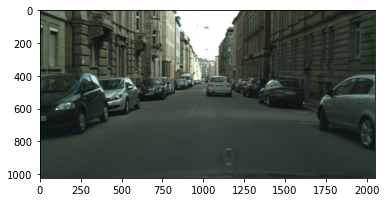

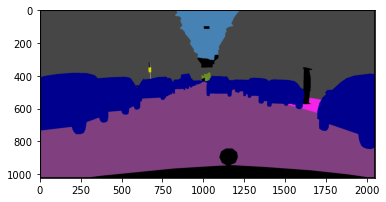

In [6]:
print_image_tensor(train_data[0][0])
print_image_tensor(train_data[0][1])

In [19]:
test_data = load_data("./datasets/cityscapes/CityScapes", "./datasets/cityscapes_labels/labels", subfolder='val/')
test_data_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=2,shuffle=True)
test_input, test_target = test_data_loader.__iter__().__next__()

In [44]:
from matplotlib import pyplot as plt
def print_image_tensor(list_tensors):
    for i, x in enumerate(list_tensors):
        x = x.permute(1,2,0)
        fig = plt.figure(figsize=(6, 20))
        fig.add_subplot(len(list_tensors),1, i+1)
        plt.imshow(x.numpy())
        plt.axis('off')
    plt.show()
    

torch.Size([2, 3, 1024, 2048])
torch.Size([2, 3, 1024, 2048])


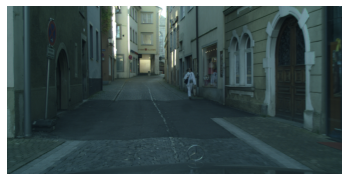

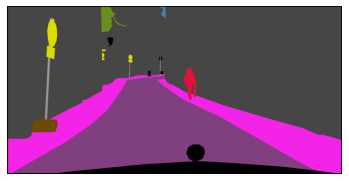

In [45]:
print(test_input.size())
print(test_target.size())
print_image_tensor([test_input[1],test_target[1]])


In [8]:
torch.cuda.empty_cache()
G = Generator(3, 64, 3)
D = Discriminator(6)
G.cuda()
D.cuda()

BCE_loss = nn.BCELoss().cuda()
L1_loss = nn.L1Loss().cuda()

G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
import numpy as np
def plot_test_result(input, target, gen_image, epoch, training=True):
    
    fig, axes = plt.subplots(1, 3)
    imgs = [input, gen_image, target]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = (((img[0] - img[0].min()) * 255) / (img[0].max() - img[0].min())).detach().numpy().transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    if training:
        title = 'Epoch {0}'.format(epoch + 1)
        fig.text(0.5, 0.04, title, ha='center')

    plt.show()
    

0
Epoch [1/200], Step [1/98], D_loss: 0.7188, G_loss: 60.6016
Epoch [1/200], Step [21/98], D_loss: 0.4877, G_loss: 21.8504
Epoch [1/200], Step [41/98], D_loss: 0.2411, G_loss: 19.4525
Epoch [1/200], Step [61/98], D_loss: 0.1360, G_loss: 17.8623
Epoch [1/200], Step [66/98], D_loss: 0.3358, G_loss: 22.9775
Epoch [1/200], Step [81/98], D_loss: 0.4033, G_loss: 18.0812
1
Epoch [2/200], Step [1/98], D_loss: 0.3861, G_loss: 15.7671
Epoch [2/200], Step [21/98], D_loss: 0.3253, G_loss: 16.0039
Epoch [2/200], Step [41/98], D_loss: 0.5037, G_loss: 15.9914
Epoch [2/200], Step [61/98], D_loss: 0.2174, G_loss: 14.3354
Epoch [2/200], Step [66/98], D_loss: 0.5543, G_loss: 15.1786
Epoch [2/200], Step [81/98], D_loss: 0.3657, G_loss: 17.5442
2
Epoch [3/200], Step [1/98], D_loss: 0.2007, G_loss: 10.8174
Epoch [3/200], Step [21/98], D_loss: 0.4536, G_loss: 11.3119
Epoch [3/200], Step [41/98], D_loss: 1.1228, G_loss: 10.5986
Epoch [3/200], Step [61/98], D_loss: 0.4432, G_loss: 13.5422
Epoch [3/200], Step [

Epoch [23/200], Step [21/98], D_loss: 0.4360, G_loss: 10.3696
Epoch [23/200], Step [41/98], D_loss: 0.3495, G_loss: 7.3456
Epoch [23/200], Step [61/98], D_loss: 0.2632, G_loss: 5.5995
Epoch [23/200], Step [66/98], D_loss: 0.0730, G_loss: 10.7350
Epoch [23/200], Step [81/98], D_loss: 0.0733, G_loss: 11.4655
23
Epoch [24/200], Step [1/98], D_loss: 0.3432, G_loss: 9.2331
Epoch [24/200], Step [21/98], D_loss: 0.0387, G_loss: 7.5817
Epoch [24/200], Step [41/98], D_loss: 0.0919, G_loss: 9.6257
Epoch [24/200], Step [61/98], D_loss: 0.0058, G_loss: 12.1498
Epoch [24/200], Step [66/98], D_loss: 0.0093, G_loss: 10.3969
Epoch [24/200], Step [81/98], D_loss: 0.5361, G_loss: 12.3613
24
Epoch [25/200], Step [1/98], D_loss: 0.0241, G_loss: 11.8628
Epoch [25/200], Step [21/98], D_loss: 0.2404, G_loss: 10.8280
Epoch [25/200], Step [41/98], D_loss: 0.1250, G_loss: 8.3948
Epoch [25/200], Step [61/98], D_loss: 0.0705, G_loss: 12.9471
Epoch [25/200], Step [66/98], D_loss: 0.3418, G_loss: 8.4435
Epoch [25/2

Epoch [45/200], Step [41/98], D_loss: 0.0054, G_loss: 10.8900
Epoch [45/200], Step [61/98], D_loss: 0.2058, G_loss: 9.8476
Epoch [45/200], Step [66/98], D_loss: 0.2242, G_loss: 10.2570
Epoch [45/200], Step [81/98], D_loss: 0.0605, G_loss: 9.4130
45
Epoch [46/200], Step [1/98], D_loss: 0.1300, G_loss: 7.9942
Epoch [46/200], Step [21/98], D_loss: 0.0612, G_loss: 9.3981
Epoch [46/200], Step [41/98], D_loss: 0.7375, G_loss: 9.4445
Epoch [46/200], Step [61/98], D_loss: 0.0318, G_loss: 11.1411
Epoch [46/200], Step [66/98], D_loss: 0.1302, G_loss: 8.4147
Epoch [46/200], Step [81/98], D_loss: 0.0633, G_loss: 8.9067
46
Epoch [47/200], Step [1/98], D_loss: 0.0261, G_loss: 8.4697
Epoch [47/200], Step [21/98], D_loss: 0.3081, G_loss: 9.6103
Epoch [47/200], Step [41/98], D_loss: 0.5826, G_loss: 10.4521
Epoch [47/200], Step [61/98], D_loss: 0.0813, G_loss: 10.9843
Epoch [47/200], Step [66/98], D_loss: 0.0581, G_loss: 11.3699
Epoch [47/200], Step [81/98], D_loss: 1.7393, G_loss: 6.8682
47
Epoch [48/2

Epoch [67/200], Step [61/98], D_loss: 0.9004, G_loss: 8.8836
Epoch [67/200], Step [66/98], D_loss: 0.3104, G_loss: 6.5190
Epoch [67/200], Step [81/98], D_loss: 0.0851, G_loss: 10.6393
67
Epoch [68/200], Step [1/98], D_loss: 0.0212, G_loss: 10.6426
Epoch [68/200], Step [21/98], D_loss: 0.0046, G_loss: 10.3105
Epoch [68/200], Step [41/98], D_loss: 0.1173, G_loss: 7.6689
Epoch [68/200], Step [61/98], D_loss: 0.0404, G_loss: 10.0434
Epoch [68/200], Step [66/98], D_loss: 0.0504, G_loss: 6.5671
Epoch [68/200], Step [81/98], D_loss: 0.0360, G_loss: 6.9625
68
Epoch [69/200], Step [1/98], D_loss: 0.0361, G_loss: 10.7874
Epoch [69/200], Step [21/98], D_loss: 0.0036, G_loss: 9.9906
Epoch [69/200], Step [41/98], D_loss: 0.0604, G_loss: 10.5894
Epoch [69/200], Step [61/98], D_loss: 0.1051, G_loss: 11.2010
Epoch [69/200], Step [66/98], D_loss: 0.0045, G_loss: 9.1530
Epoch [69/200], Step [81/98], D_loss: 0.0039, G_loss: 9.2834
69
Epoch [70/200], Step [1/98], D_loss: 0.1731, G_loss: 10.4977
Epoch [70/

Epoch [89/200], Step [66/98], D_loss: 0.0149, G_loss: 9.0787
Epoch [89/200], Step [81/98], D_loss: 0.0331, G_loss: 8.1844
89
Epoch [90/200], Step [1/98], D_loss: 0.1457, G_loss: 9.8798
Epoch [90/200], Step [21/98], D_loss: 0.0509, G_loss: 7.5187
Epoch [90/200], Step [41/98], D_loss: 0.0230, G_loss: 10.3158
Epoch [90/200], Step [61/98], D_loss: 0.2697, G_loss: 7.2306
Epoch [90/200], Step [66/98], D_loss: 0.0222, G_loss: 6.8993
Epoch [90/200], Step [81/98], D_loss: 0.0502, G_loss: 8.4301
90
Epoch [91/200], Step [1/98], D_loss: 0.0093, G_loss: 11.3182
Epoch [91/200], Step [21/98], D_loss: 0.0088, G_loss: 10.1735
Epoch [91/200], Step [41/98], D_loss: 0.3753, G_loss: 7.4386
Epoch [91/200], Step [61/98], D_loss: 0.0637, G_loss: 7.9454
Epoch [91/200], Step [66/98], D_loss: 0.0147, G_loss: 7.8135
Epoch [91/200], Step [81/98], D_loss: 0.0083, G_loss: 8.9210
91
Epoch [92/200], Step [1/98], D_loss: 0.7339, G_loss: 9.8506
Epoch [92/200], Step [21/98], D_loss: 0.0052, G_loss: 10.5977
Epoch [92/200]

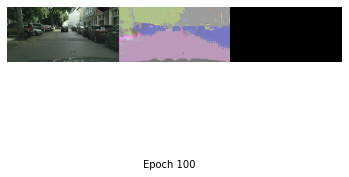

In [10]:
D_avg_losses = []
G_avg_losses = []


for epoch in range(100):
    print(epoch)
    D_losses = []
    G_losses = []

    # training
    for i,(input, target) in enumerate(train_data_loader):
       
        # input & target image data
        x_ = input.cuda()
        y_ = target.cuda()
        #print(y_.shape)
        
        # Train discriminator with real data
        D_real_decision = D(x_, y_).squeeze()
        real_ = torch.ones(D_real_decision.size()).cuda()
        D_real_loss = BCE_loss(D_real_decision, real_)

        # Train discriminator with fake data
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        fake_ = torch.zeros(D_fake_decision.size()).cuda()
        D_fake_loss = BCE_loss(D_fake_decision, fake_)

        # Back propagation
        D_loss = (D_real_loss + D_fake_loss) * 0.5
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Train generator
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        # L1 loss
        l1_loss =100 * L1_loss(gen_image, y_) #(lambda value=100)

        # Back propagation
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # loss values
        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if(i%20==0 or i%65==0):
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'
                 % (epoch+1, 200, i+1, len(train_data_loader), D_loss.item(), G_loss.item()))

    D_avg_loss = torch.mean(torch.FloatTensor(D_losses))
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses))

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)
    

    #Show result for test image
    gen_image = G(test_input.cuda())
    gen_image = gen_image.cpu()
plot_test_result(test_input, test_target, gen_image, epoch)